<a href="https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/02_Aversarial_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# AIPI 590 - XAI | Assignment 02

#Description: Adversarial Patch
This notebook enables one to create and evaluate adversarial patches as a white box adversarial technique.

## Chad Miller

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/02_Aversarial_patches.ipynb)

Acknowledgements: Class Repository, Notebook 'Tutorial 10: Adversarial attacks" authored by Phillip Lippe

In [2]:
import os

# Remove Colab default sample_data
!rm -r /content/sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590-XAI"
git_path = 'https://github.com/mille055/AIPI590-XAI.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"


notebook_dir = 'Assignments'
path_to_notebook = os.path.join(repo_name,notebook_dir)


Cloning into 'AIPI590-XAI'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 56 (delta 27), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 45.08 KiB | 11.27 MiB/s, done.
Resolving deltas: 100% (27/27), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.3 MB/s eta 0:00:00


In [3]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import tabulate
import urllib.request
import zipfile

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet




In [4]:
# Get secrets if necessary
# from google.colab import userdata
# userdata.get('secretName')

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print('device is ', device)

device is  cuda:0


In [6]:
%ls

AIPI590-XAI/


In [7]:
# Define the paths where the zip files will be downloaded and extracted
DATA_PATH = 'AIPI590-XAI/Assignments/data'
CHECKPOINT_PATH = 'AIPI590-XAI/Assignments/checkpoints'

# Ensure the directories exist
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Base URL for the files
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"

# List of files to download (path, filename)
pretrained_files = [
    (DATA_PATH, "TinyImageNet.zip"),
    (CHECKPOINT_PATH, "patches.zip")
]

# Download and extract each file
for path, filename in pretrained_files:
    # Create the full download URL and the local file path
    file_url = base_url + filename
    file_path = os.path.join(path, filename)

    # Download the file if it doesn't already exist
    if not os.path.exists(file_path):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(file_url, file_path)
        print(f"Downloaded {filename}.")
    else:
        print(f"{filename} already exists.")

    # Extract the zip file
    print(f"Extracting {filename}...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(path)
    print(f"Extracted {filename}.")

print("All files downloaded and extracted.")

Downloaded TinyImageNet.zip.
Extracting TinyImageNet.zip...
Extracted TinyImageNet.zip.
Downloaded patches.zip.
Extracting patches.zip...
Extracted patches.zip.
All files downloaded and extracted.


In [8]:


# Define the path to the TinyImageNet dataset
data_dir = 'AIPI590-XAI/Assignments/data/TinyImageNet'

# Define transformations
preprocess = transforms.Compose([
    #transforms.Resize(256), # already preprocessed
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset using ImageFolder
tiny_imagenet_dataset = datasets.ImageFolder(root=data_dir, transform=preprocess)

# DataLoader for batching the images
data_loader = DataLoader(tiny_imagenet_dataset, batch_size=32, shuffle=True)

# Number of classes in the dataset
num_classes = len(tiny_imagenet_dataset.classes)
print(f'Number of classes: {num_classes}')

# Example: Access one batch of images and labels
images, labels = next(iter(data_loader))
print(f'Batch of images shape: {images.shape}')
print(f'Batch of labels: {labels}')


Number of classes: 1000
Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels: tensor([980,   3, 932, 827, 209, 119, 613, 465, 368, 147, 815, 591, 405,  89,
        665, 796, 267, 264, 856, 689, 172, 843, 232,  54, 757, 669, 477, 211,
        998, 354, 885, 452])


In [9]:
# Get the model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 69.1MB/s]


In [10]:
# Some constant values

# ImageNet mean and std
#NORM_MEAN = [0.4914, 0.4822, 0.4465]
#NORM_STD = [0.2023, 0.1994, 0.2010]
#TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]

# Transforms
##plain_transforms = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=NORM_MEAN,
#                         std=NORM_STD)
#])

# Patch information
class_names = ['basketball']
patch_sizes = [32, 48, 64]

with open(os.path.join('/content/', path_to_notebook, 'imagenet_classes.txt'), 'r') as f:
  label_names = [line.strip() for line in f.readlines()]
  target_class = label_names.index('basketball')


In [11]:
# places patch in random location without rotation
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [12]:
# places patch in random location with rotation
def place_patch(img, patch):
    for i in range(img.shape[0]):
        # Rotate random amount between 0 and 360 degrees
        angle = np.random.uniform(0, 360)
        rotated_patch = TF.rotate(patch, angle)

        # Ensure the rotated patch still fits within the image
        h_offset = np.random.randint(0, img.shape[2] - rotated_patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - rotated_patch.shape[2] - 1)

        # Apply the patch to the image at the random location
        img[i, :, h_offset:h_offset+rotated_patch.shape[1], w_offset:w_offset+rotated_patch.shape[2]] = patch_forward(rotated_patch)

    return img

In [13]:

def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [14]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [15]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    #!mkdir -p data # create a directory to store the data if it doesn't exist
    dataset = ImageNet(root='AIPI590-XAI/Assingments/data', train=True, download=True, transform=transforms.ToTensor())
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [16]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [17]:
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATA_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]

In [18]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [19]:
patch_dict = get_patches(class_names, patch_sizes)
# save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in AIPI590-XAI/Assingments/data.

NameError: name 'patch_dict' is not defined

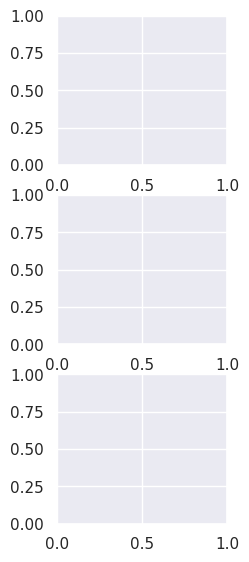

In [20]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [ ]:

from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))